<a href="https://colab.research.google.com/github/DanielHevdeli/hafifot-tiug/blob/main/train_bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/DanielHevdeli/hafifot-tiug.git

In [60]:
import pandas as pd

In [61]:
posts_df = pd.read_csv("./hafifot-tiug/data/split_data/present.csv")

In [62]:
print(f"Num of posts: {len(posts_df)}")

Num of posts: 4000


In [63]:
labels_df = pd.read_csv("./hafifot-tiug/data/labels/present/dummy-gpt-4_labels.csv")

In [64]:
merged_df = pd.merge(posts_df[['question_id', 'text']], labels_df, on='question_id')
posts_with_labels_df = merged_df[['question_id', 'text', 'label']]

# Create a BERT Classifier

In [65]:
import torch
from torch import nn
import transformers
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
    EarlyStoppingCallback
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, classification_report
from torchsummary import summary
from datasets import Dataset, DatasetDict
import numpy as np
import matplotlib.pyplot as plt

In [66]:
label2id = {"non-suicidal": 0, "suicidal": 1}
id2label = {0: "non-suicidal", 1: "suicidal"}
df = posts_with_labels_df.copy()
df["labels"] = df["label"].map(label2id)


In [67]:
TEST_SIZE = 0.2

In [68]:
train_df, test_df = train_test_split(df, test_size=TEST_SIZE, stratify=df["labels"], random_state=42)
train_df, val_df = train_test_split(train_df, test_size=TEST_SIZE, stratify=train_df["labels"], random_state=42)

In [69]:
train_ds = Dataset.from_pandas(train_df[["text", "labels"]])
val_ds   = Dataset.from_pandas(val_df[["text", "labels"]])
test_ds  = Dataset.from_pandas(test_df[["text", "labels"]])

ds = DatasetDict({"train": train_ds, "validation": val_ds, "test": test_ds})

In [70]:
MODEL_NAME = "onlplab/alephbert-base" #FIX: truncation of all posts...
model_short_name = MODEL_NAME.split("/")[-1]
MODEL_CONTEXT_LEN = 512
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

In [ ]:
def tokenize(batch):
    return tokenizer(batch["text"], truncation=True, max_length=MODEL_CONTEXT_LEN)

ds = ds.map(tokenize, batched=True)

In [72]:
ds = ds.remove_columns(["text"])
ds.set_format(type="torch")

In [73]:
ds

DatasetDict({
    train: Dataset({
        features: ['labels', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2560
    })
    validation: Dataset({
        features: ['labels', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 640
    })
    test: Dataset({
        features: ['labels', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 800
    })
})

In [74]:
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(id2label),
    id2label=id2label,
    label2id=label2id
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at onlplab/alephbert-base and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [75]:
# print summary

In [76]:
print(model)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(52000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [77]:
def compute_metrics(pred):
    logits, labels = pred
    preds = np.argmax(logits, axis=-1)

    acc = accuracy_score(labels, preds)
    # precision_per_class, recall_per_class, f1_per_class, _ = precision_recall_fscore_support(
    #     labels, preds, average=None, zero_division=0
    # )
    # min accuracy
    correct_per_class = []
    for cls in [0, 1]:
        mask = (labels == cls)
        class_acc = (preds[mask] == cls).sum() / mask.sum()
        correct_per_class.append(class_acc)
    min_acc = min(correct_per_class)

    return {
        "accuracy": acc,
        "min_accuracy": min_acc,
    }

In [78]:
BATCH_SIZE = 16
EPOCHS = 10

In [79]:
training_args = TrainingArguments(
    report_to=[],  # I dont want to save my expirements to W&B or tensorboard
    output_dir=f"./hafifot-tiug/models/{model_short_name}",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="min_accuracy",
    greater_is_better=True,
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    fp16=True
)

In [80]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [81]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=ds["train"],
    eval_dataset=ds["validation"],
    processing_class=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    # callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

In [82]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Min Accuracy
1,0.725600,0.693748,0.501563,0.000000
2,0.706300,0.700636,0.503125,0.000000
3,0.715100,0.716582,0.503125,0.000000
4,0.655400,0.814983,0.476562,0.358491
5,0.379100,1.245611,0.489063,0.378882
6,0.175200,2.412529,0.460938,0.358491
7,0.070900,2.814553,0.475000,0.409938
8,0.046000,3.241700,0.464062,0.308176
9,0.027700,3.246682,0.453125,0.352201
10,0.027400,3.385352,0.450000,0.355346


TrainOutput(global_step=1600, training_loss=0.3528682994842529, metrics={'train_runtime': 902.3498, 'train_samples_per_second': 28.37, 'train_steps_per_second': 1.773, 'total_flos': 6655468145315520.0, 'train_loss': 0.3528682994842529, 'epoch': 10.0})

In [83]:
history = trainer.state.log_history

train_logs = [h for h in trainer.state.log_history if "loss" in h and "eval_loss" not in h]
val_logs   = [h for h in trainer.state.log_history if "eval_loss" in h]

In [84]:
def extract(logs, keys):
    data = {k: [] for k in keys}
    for h in logs:
        for k in keys:
            data[k].append(h.get(k, None))
    return data

train_loss = extract(train_logs, ["loss"])
val_metrics = extract(val_logs, ["eval_loss", "eval_accuracy", "eval_min_accuracy"])


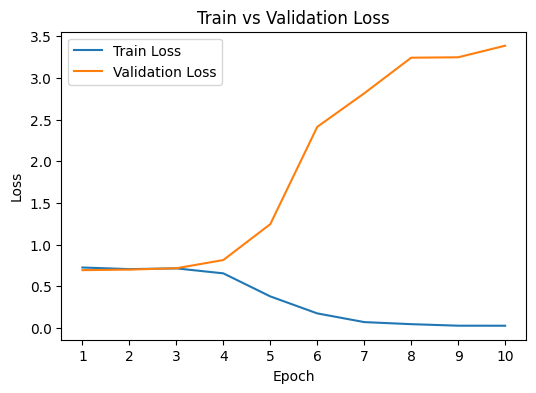

In [85]:
epochs = range(1, len(train_loss["loss"]) + 1)

plt.figure(figsize=(6,4))
plt.plot(epochs, train_loss["loss"], label="Train Loss")
plt.plot(epochs, val_metrics["eval_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.xticks(epochs)
plt.ylabel("Loss")
plt.title("Train vs Validation Loss")
plt.legend()
plt.show()

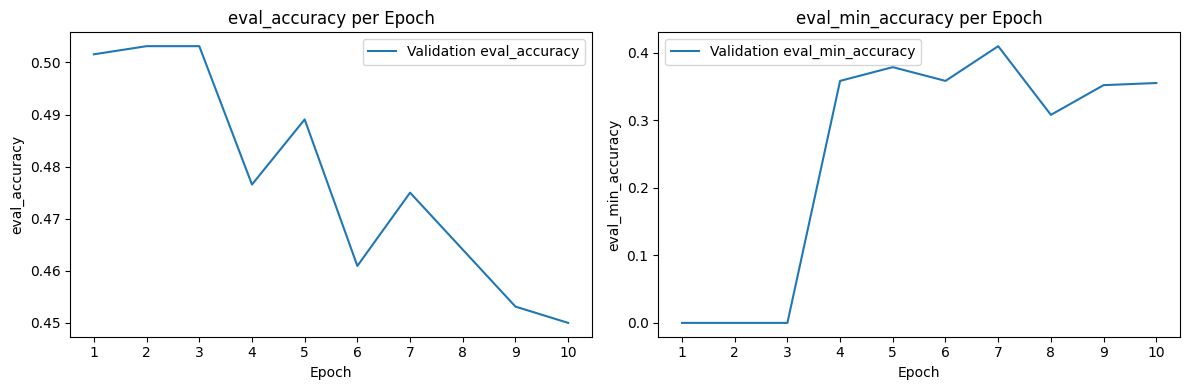

In [86]:
metric_names = ["eval_accuracy", "eval_min_accuracy"]
num_metrics = len(metric_names)

# create a single row of subplots
fig, axes = plt.subplots(1, num_metrics, figsize=(6*num_metrics, 4))  # width scales with number of metrics

for i, metric in enumerate(metric_names):
    ax = axes[i] if num_metrics > 1 else axes
    ax.plot(epochs, val_metrics[metric], label=f"Validation {metric}")
    ax.set_xlabel("Epoch")
    ax.set_xticks(epochs)
    ax.set_ylabel(metric)
    ax.set_title(f"{metric} per Epoch")
    ax.legend()

plt.tight_layout()
plt.show()

In [87]:
def print_classification_report(texts, title):
    pred = trainer.predict(texts)
    logits = pred.predictions
    labels = pred.label_ids
    preds = logits.argmax(-1)

    print(f"\n====== CLASSIFICATION REPORT ({title}) ======\n")
    print(classification_report(labels, preds, target_names=list(id2label.values())))

In [88]:
print_classification_report(ds["train"], title="Train")


====== CLASSIFICATION REPORT (Train) ======

              precision    recall  f1-score   support

non-suicidal       1.00      0.99      1.00      1290
    suicidal       0.99      1.00      1.00      1270

    accuracy                           1.00      2560
   macro avg       1.00      1.00      1.00      2560
weighted avg       1.00      1.00      1.00      2560



In [89]:
print_classification_report(ds["validation"], title="Validation")


====== CLASSIFICATION REPORT (Validation) ======

              precision    recall  f1-score   support

non-suicidal       0.47      0.41      0.44       322
    suicidal       0.48      0.54      0.51       318

    accuracy                           0.47       640
   macro avg       0.47      0.48      0.47       640
weighted avg       0.47      0.47      0.47       640



Clearly overfitting! I will fix it later

In [90]:
def predict(texts):
    enc = tokenizer(texts, truncation=True, padding=True, return_tensors="pt").to(model.device)
    with torch.no_grad():
      logits = model(**enc).logits
    preds = logits.argmax(dim=-1).cpu().numpy()
    return [id2label[int(p)] for p in preds]

In [91]:
print(predict([
    "כבר תקופה אני מרגישה ממש רע",
    "איזה יום טוב היה לי היום"
]))

['suicidal', 'suicidal']


In [92]:
# print_classification_report(ds["test"], title="Test")